# **Ayudantía 7 - Newton $\mathbb{R}^n$**
## Etienne Rojas

Ante cualquier duda o posible corrección, por favor mandar un correo a `etienne.rojas@sansano.usm.cl` 

---

# **CONTEXTO**

En una taza de agua caliente se disuelven pequeñas cantidades de café soluble, creando cinco zonas iniciales de alta concentración.  
Al revolver el café utilizando un mini batidor, se generan corrientes internas modeladas por un campo de velocidad con la forma de un remolino.

La concentración de café en la taza sigue la ecuación de **advección-difusión bidimensional**:



$$
\frac{\partial c}{\partial t} + u(x,y) \frac{\partial c}{\partial x} + v(x,y) \frac{\partial c}{\partial y} = D \Delta c
$$

Donde:


- $c(x,y,t)$ es la **concentración del café**, es decir, la cantidad de café en un punto $(x,y)$ en el instante $t$.
- $u(x,y)$ y $v(x,y)$ son los **campos de velocidades**, describiendo cómo se mueve el fluido en cada punto: $u$ en la dirección $x$, $v$ en la dirección $y$.
- $D$ es el **coeficiente de difusión**, que mide la tendencia natural del café a extenderse espontáneamente y suavizarse.
- $\Delta c$ es el **Laplaciano de $c$**, que mide la curvatura de $c$ y controla el efecto de la difusión espacial.
- Las condiciones de borde con periódicas.



Además considere que usted conoce los siguientes elementos:

1. Los **campos de velocidades** estan dados por:
$$
\begin{aligned}
u(x,y) &= sin(\pi x) cos(\pi y)\\
v(x,y) &=-cos(\pi x) sin(\pi y)
\end{aligned}
$$

2. El **coeficiente de difusión** $D$ es un valor conocido:
$$
D = 0.0005
$$

3. Las condiciones de borde son periódicas.

4. El dominio es cuadrado
$$
(x,y) = \in [0,1] \times [0,1]
$$

5. La condición inical $c(x,y,0)$ consiste en 5 pequeñas concentraciones de café distribuidas equiespaciadamente formando un pentágono. Cada concentración se modela con la siguiente función:
$$
c(x,y,0) = \sum_{i=1}^5 exp(-\alpha ((x-x_i)^2 + (y-y_i)^2))
$$
Tal que $(x_i,y_i)$ son las posiciones de las concentraciones iniciales de café, alpha una constante $\alpha=100$


## **PREGUNTA 1**



Se desea determinar la distribución final de la concentración de café en la taza, correspondiente a un estado de mezcla homogénea estacionaria.

**a)** ¿Cómo puede plantearse matemáticamente el problema de encontrar una configuración $c(x,y)$ donde la concentración no cambie en el tiempo?

**b)** Una vez planteado este problema, ¿qué tipo de ecuación o sistema se debe resolver?

**c)** ¿Qué método numérico apropiado podría utilizarse para resolver este problema en un dominio discretizado?

---

# **PAUTA 1**

**a)** El estado homogéneo se da cuando el café está completamente mezclado y su concentración deja de cambiar en el tiempo, es decir:
$$
\frac{\partial c}{\partial t} = 0
$$

Esto hace que la ecuación de advección-difusión en el estado estacionario quede de la siguiente forma:

$$
u(x,y) \frac{\partial c}{\partial x} + v(x,y)\frac{\partial c}{\partial y} = D \Delta c
$$

**b)** Discretiazmos el dominio en una malla de puntos. Cada punto de la malla nos da una ecuación. de donde salen $n \times n$ ecuaciones. El problema queda planteado como la búsqueda de $c$ tal que:
$$
F(c) = 0
$$
Donde $F$ es un operador que aplica la advección y difusión discretizada.

**c)** LLegamos a un sistema de ecuaciones no lineales, así que podemos usar el método de Newton en $\mathbb{R}^n$, esto genera la problematica del Jacobiano, tenemos que construirlo o aproximarlo para cada iteración.



---

# **PROGRAMACIÓN**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.ndimage import map_coordinates


In [7]:
# ----------------------------
# Parámetros globales
n = 100              # Número de puntos en cada dirección
dt = 0.05            # Paso de tiempo
D = 0.0005           # Coeficiente de difusión
domain_size = (0, 1) # Dominio espacial


### **FUNCIONES AUXILIARES**

In [12]:

def velocity_field(X, Y):
    """Define el campo de velocidad."""
    u = np.sin(np.pi * X) * np.cos(np.pi * Y)
    v = -np.cos(np.pi * X) * np.sin(np.pi * Y)
    return u, v

def initial_concentration(X, Y):
    """Crea 5 concentraciones formando un pentágono de concentración inicial."""
    c0 = np.zeros_like(X)
    center_x, center_y = 0.5, 0.5
    radius = 0.45
    angles = np.linspace(0, 2*np.pi, 6)[:-1]  

    for angle in angles:
        px = center_x + radius * np.cos(angle)
        py = center_y + radius * np.sin(angle)
        c0 += np.exp(-100 * ((X - px)**2 + (Y - py)**2))
    return c0

def plot_concentration(c, title='Estado Estacionario'):
    """Grafica la concentración."""
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(
        c, extent=(0,1,0,1), origin='lower', cmap='plasma',
        vmin=0, vmax=1
    )
    plt.axis('off')
    cbar = plt.colorbar(im, ax=ax, label='Concentración')
    cbar.set_ticks(np.linspace(0, 1, 6))
    plt.title(title)
    plt.show()

### **FUNCIONES A COMPLETAR**

In [13]:
def compute_residual(c_flat, X, Y, u, v, dt, D):
    """
    Calcula el residuo F(c) = evolución(c) - c, para el sistema de advección-difusión.

    Parámetros:
    - c_flat: ndarray de forma (n²,), concentración actual aplanada en un vector.
    - X, Y: mallas espaciales 2D con las coordenadas (x, y).
    - u, v: componentes del campo de velocidad en cada punto.
    - dt: paso de tiempo.
    - D: coeficiente de difusión.

    Retorna:
    - F(c): ndarray de forma (n²,), residuo de la evolución (vector).
    """
    n = X.shape[0]
    c = c_flat.reshape((n, n))
    
    X_new = X - u * dt
    Y_new = Y - v * dt
    
    X_new = np.mod(X_new, 1)
    Y_new = np.mod(Y_new, 1)
    coords = np.array([Y_new.flatten() * (n-1), X_new.flatten() * (n-1)])
    c_advected = map_coordinates(c, coords, order=1, mode='wrap').reshape(n, n)
    
    laplacian = (
    np.roll(c_advected, 1, axis=0) +   
    np.roll(c_advected, -1, axis=0) +  
    np.roll(c_advected, 1, axis=1) +   
    np.roll(c_advected, -1, axis=1)   
    - 4 * c_advected                  
)
    c_diffused = c_advected + D * laplacian
    
    return (c_diffused - c).flatten()
def approximate_jacobian(F, c, epsilon=1e-6):
    """
    Aproxima la matriz Jacobiana J_F de la función F en el punto c usando diferencias finitas.

    Parámetros:
    - F: función que evalúa el residuo F(c).
    - c: ndarray de forma (n²,), concentración actual aplanada.
    - epsilon: perturbación pequeña usada para diferencias finitas (default 1e-6).

    Retorna:
    - J: ndarray de forma (n², n²), matriz Jacobiana aproximada.
    """
    n2 = c.size
    J = np.zeros((n2, n2))
    F0 = F(c)  
    
    for i in range(n2):
        e_i = np.zeros(n2)
        e_i[i] = 1.0
        F_perturbed = F(c + epsilon * e_i)
        J[:, i] = (F_perturbed - F0)/epsilon
    
    return J
def newton_solver(F, c0_flat, tol=1e-6, max_iter=20):
    """
    Resuelve F(c) = 0 utilizando el método de Newton.

    Parámetros:
    - F: función que evalúa el residuo F(c).
    - c0_flat: ndarray de forma (n²,), concentración inicial aplanada.
    - tol: tolerancia para la norma del residuo que indica convergencia (default 1e-6).
    - max_iter: número máximo de iteraciones permitidas (default 20).

    Retorna:
    - c_steady: ndarray de forma (n²,), solución aproximada donde F(c) ≈ 0.
    """
    c = c0_flat.copy()
    for iteration in range(max_iter):
        F_c = F(c)
        norm_F = np.linalg.norm(F_c)
        print(f"Iteración {iteration}: ||F(c)|| = {norm_F:.2e}")

        if norm_F < tol:
            print("Convergencia alcanzada.")
            break

        J = approximate_jacobian(F, c)
        delta_c = np.linalg.solve(J, -F_c)
        c += delta_c

    return c
    

### **GRAFICAR RESULTADOS**

Iniciando Newton clásico...
Iteración 0: ||F(c)|| = 1.11e+01
Iteración 1: ||F(c)|| = 1.18e-08
Convergencia alcanzada.


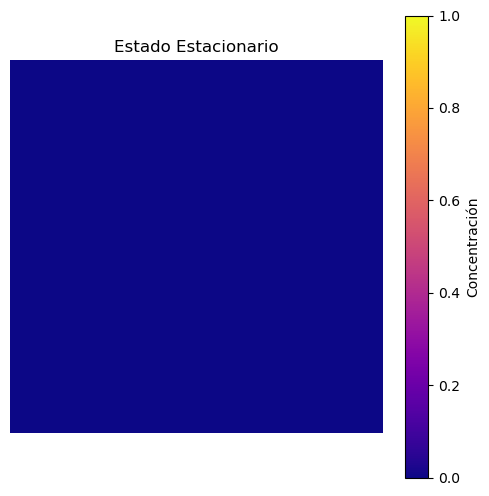

In [16]:
x = np.linspace(*domain_size, n)
y = np.linspace(*domain_size, n)
X, Y = np.meshgrid(x, y)

u, v = velocity_field(X, Y)
c0 = initial_concentration(X, Y)
c0_flat = c0.flatten()

def F(c_flat):
    return compute_residual(c_flat, X, Y, u, v, dt, D)

print("Iniciando Newton clásico...")
c_steady_flat = newton_solver(F, c0_flat, tol=1e-6, max_iter=20)

c_steady = c_steady_flat.reshape((n, n))
plot_concentration(c_steady)


> Tenemos una malla de 100X100 puntos, un sistema relativamente sencillo y Newton es lento. Cuando aprenda GMRES vuelva a visitar este código y piense en posibles mejoras.

# CODIGO OPCION 2

Iniciando simulación temporal...
Convergencia alcanzada en t = 47.15 segundos (943 pasos).
¡Animación guardada como 'evolucion_cafe.mp4'!


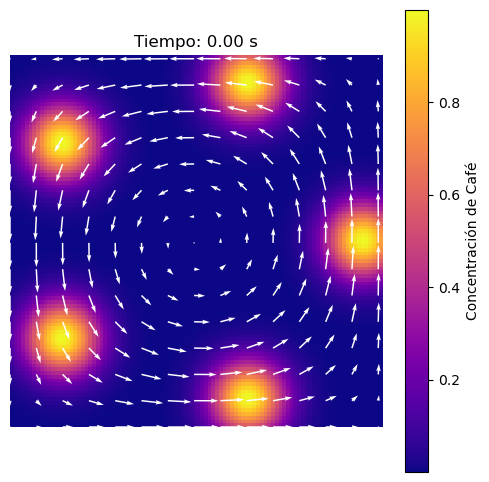

In [ ]:
# -------------------------
# Parámetros
tolerance = 1e-6
max_steps = 5000 

def one_step_evolution(c, X, Y, u, v, dt, D):
    """Realiza un paso de advección-difusión."""
    n = X.shape[0]

    X_new = np.mod(X - u * dt, 1)
    Y_new = np.mod(Y - v * dt, 1)
    coords = np.array([Y_new.flatten() * (n-1), X_new.flatten() * (n-1)])
    c_advected = map_coordinates(c, coords, order=1, mode='wrap').reshape(n, n)

    laplacian = (
        np.roll(c_advected, 1, axis=0) + np.roll(c_advected, -1, axis=0) +
        np.roll(c_advected, 1, axis=1) + np.roll(c_advected, -1, axis=1) -
        4 * c_advected
    )
    c_diffused = c_advected + D * laplacian

    return c_diffused

def plot_concentration(c, title='Concentración Final'):
    """Grafica la concentración."""
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(c, extent=(0,1,0,1), origin='lower', cmap='plasma')
    plt.axis('off')
    plt.colorbar(im, ax=ax, label='Concentración de Café')
    plt.title(title)
    plt.show()

# ----------------------------
# Programa principal

# Crear malla espacial
x = np.linspace(*domain_size, n)
y = np.linspace(*domain_size, n)
X, Y = np.meshgrid(x, y)

# Condición inicial y velocidad
u, v = velocity_field(X, Y)
c = initial_concentration(X, Y)

# Evolución temporal
c_list = [c.copy()]
t = 0.0

print("Iniciando simulación temporal...")

for step in range(max_steps):
    c_next = one_step_evolution(c, X, Y, u, v, dt, D)
    
    # Criterio de parada basado en ||c_next - c||
    change = np.linalg.norm(c_next - c)
    if change < tolerance:
        print(f"Convergencia alcanzada en t = {t:.2f} segundos ({step} pasos).")
        break

    c = c_next.copy()
    c_list.append(c.copy())
    t += dt

else:
    print("No se alcanzó la convergencia en el máximo de pasos permitido.")

# ----------------------------
# Animación
fig, ax = plt.subplots(figsize=(6,6))
skip = 7
im = ax.imshow(c_list[0], extent=(0,1,0,1), origin='lower', cmap='plasma')
quiv = ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], u[::skip, ::skip], v[::skip, ::skip], color='white', scale=15)
plt.axis('off')
plt.colorbar(im, ax=ax, label='Concentración de Café')

def update(frame):
    im.set_data(c_list[frame])
    ax.set_title(f'Tiempo: {frame*dt:.2f} s')
    return im, quiv

ani = animation.FuncAnimation(fig, update, frames=len(c_list), interval=50, blit=False)

ani.save('evolucion_cafe.mp4', writer='ffmpeg', fps=20)
print("¡Animación guardada como 'evolucion_cafe2.mp4'!")


# PAUTA
```python
def compute_residual(c_flat, X, Y, u, v, dt, D):
    n = X.shape[0]
    c = c_flat.reshape((n, n))
    
    X_new = X - u * dt
    Y_new = Y - v * dt
    
    X_new = np.mod(X_new, 1)
    Y_new = np.mod(Y_new, 1)
    coords = np.array([Y_new.flatten() * (n-1), X_new.flatten() * (n-1)])
    c_advected = map_coordinates(c, coords, order=1, mode='wrap').reshape(n, n)
    
    laplacian = (
    np.roll(c_advected, 1, axis=0) +   
    np.roll(c_advected, -1, axis=0) +  
    np.roll(c_advected, 1, axis=1) +   
    np.roll(c_advected, -1, axis=1)   
    - 4 * c_advected                  
)
    c_diffused = c_advected + D * laplacian
    
    return (c_diffused - c).flatten()
```

```python
def approximate_jacobian(F, c, epsilon=1e-6):
    n2 = c.size
    J = np.zeros((n2, n2))
    F0 = F(c)  
    
    for i in range(n2):
        e_i = np.zeros(n2)
        e_i[i] = 1.0
        F_perturbed = F(c + epsilon * e_i)
        J[:, i] = (F_perturbed - F0)/epsilon
    
    return J
```

```python
def newton_solver(F, c0_flat, tol=1e-6, max_iter=20):
    c = c0_flat.copy()
    for iteration in range(max_iter):
        F_c = F(c)
        norm_F = np.linalg.norm(F_c)
        print(f"Iteración {iteration}: ||F(c)|| = {norm_F:.2e}")

        if norm_F < tol:
            print("Convergencia alcanzada.")
            break

        J = approximate_jacobian(F, c)
        delta_c = np.linalg.solve(J, -F_c)
        c += delta_c

    return c
```